In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import operator
from typing import Sequence, Annotated
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add] # 메시지
    next: str # 다음으로 라우팅할 에이전트

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_result=5)
python_repl_tool = PythonREPLTool()

# Agent node
동적으로 code agent, 또는 resarch agent가 넘어간다.
`functiools.partial`을 통해 만든다. 이 함수는 키웓드 인자를 미리 고정하여, 새 함수를 생성하는데 사용한다.

state는 나중에 동적으로 받을꺼니 안채워줘도 된다는 뜻이다.

In [4]:
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    agent_response = agent.invoke(state)
    return{
        "messages": [
            HumanMessage(content=agent_response["messages"][-1].content, name=name)
        ]
    }

In [ ]:
# def agent_node(state, agent, name):
#     response = agent.invoke(state["question"])
#     return {
#         "question": state["question"],
#         "answer": response,
#         "next": name
#     }


In [5]:
import functools
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI

research_agent = create_react_agent(ChatOpenAI(model="gpt-4o-mini"), tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

In [6]:
response = research_node(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
)

print(response)

{'messages': [HumanMessage(content='To print "Hello, World!" to the terminal in various programming languages, here are some examples:\n\n### Python\n```python\nprint("Hello, World!")\n```\n\n### JavaScript (Node.js)\n```javascript\nconsole.log("Hello, World!");\n```\n\n### Java\n```java\npublic class HelloWorld {\n    public static void main(String[] args) {\n        System.out.println("Hello, World!");\n    }\n}\n```\n\n### C\n```c\n#include <stdio.h>\n\nint main() {\n    printf("Hello, World!\\n");\n    return 0;\n}\n```\n\n### C++\n```cpp\n#include <iostream>\n\nint main() {\n    std::cout << "Hello, World!" << std::endl;\n    return 0;\n}\n```\n\n### Ruby\n```ruby\nputs "Hello, World!"\n```\n\n### Go\n```go\npackage main\n\nimport "fmt"\n\nfunc main() {\n    fmt.Println("Hello, World!")\n}\n```\n\nYou can use any of these snippets in their respective environments to print "Hello, World!" to the terminal.', additional_kwargs={}, response_metadata={}, name='Researcher')]}


# Agent Supervisor 생성

In [7]:
from pydantic import BaseModel, Field
from typing import Literal

members = ["Researcher", "Coder"]

# 다음 작업자 선택 및 옵션 목록 정의
options_for_next = ["FINISH"] + members

# 작업자 선택 응답 모델 정의: 다음 작업자를 선택하거나 작업 완료를 나타냄
class RouteResponse(BaseModel):
    next: Literal[*options_for_next] # ["Researcher", "Coder"] 이 들어가는것과 같은 뜻

In [8]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

# 관리자 간의 대화를 관리하는 감독자 역할
system_prompt = """
    You are a supervisor tasked with managing a conversation between the following workers: {members}.
    Given the following user request, respond with the worker to act next. Each worker will perform a task and respond with their results and status.
    When finished, respond with `FINISH`
"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        ("system",
         """
         Given the conversation above, who should act next?
         Or should we FINISH? Select one of: {options}
         """)
    ]
).partial(options=str(options_for_next), members=", ".join(members)) # options에 Finish, Researcher,  coder 3가지가 들어간다.

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Supervisor agnet생성
def supervisor_agent(state):
    supervisor_chain = prompt | llm.with_structured_output(RouteResponse) # 메세지를 분석하여 어디에 넘겨줄지 next에 저장하게 된다.
    
    # agent 호출
    return supervisor_chain.invoke(state)

# Code agent 만들기

In [9]:
code_system_prompt = """
Be sure to use the following font in your code for visualization.

##### 폰트 설정 #####
import platform

# OS 판단
current_os = platform.system()

if current_os == "Windows":
    # Windows 환경 폰트 설정
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕 폰트 경로
    fontprop = fm.FontProperties(fname=font_path, size=12)
    plt.rc("font", family=fontprop.get_name())
elif current_os == "Darwin":  # macOS
    # Mac 환경 폰트 설정
    plt.rcParams["font.family"] = "AppleGothic"
else:  # Linux 등 기타 OS
    # 기본 한글 폰트 설정 시도
    try:
        plt.rcParams["font.family"] = "NanumGothic"
    except:
        print("한글 폰트를 찾을 수 없습니다. 시스템 기본 폰트를 사용합니다.")

##### 마이너스 폰트 깨짐 방지 #####
plt.rcParams["axes.unicode_minus"] = False  # 마이너스 폰트 깨짐 방지
"""

# Coder Agent 생성
coder_agent= create_react_agent(
    llm,
    tools=[python_repl_tool],
    state_modifier=code_system_prompt
)

coder_node= functools.partial(agent_node, agent=coder_agent, name="Coder")

# 그래프 구성

In [10]:
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", coder_node)
workflow.add_node("Supervisor", supervisor_agent)

# 멤버 노드 > Spuervisor 노드로 엣지 추가 **
for member in members:
    workflow.add_edge(member, "Supervisor")
    
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END

def get_next(state):
    return state["next"]

# Supervisor 노드에서 조건부 엣지 추가
workflow.add_conditional_edges("Supervisor", get_next, conditional_map)

# 시작점
workflow.add_edge(START, "Supervisor")

# 그래프 컴파일
graph = workflow.compile(checkpointer=MemorySaver())

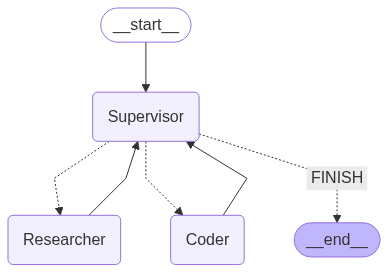

In [11]:
graph


🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
Researcher

🔄 Node: agent in [Researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_zZKmGPnyrJFEh2BJIGBJ6WMo)
 Call ID: call_zZKmGPnyrJFEh2BJIGBJ6WMo
  Args:
    query: South Korea GDP per capita 2010 to 2024

🔄 Node: tools in [Researcher] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "South Korea GDP per Capita | Economic Indicators - CEIC", "url": "https://www.ceicdata.com/en/indicator/korea/gdp-per-capita", "content": "South Korea Gross Domestic Product (GDP) per Capita reached 36,113.000 USD in Dec 2024, compared with 35,569.900 USD in Dec 2023.\nSouth Korea GDP Per Capita data is updated yearly, available from Dec 1953 to Dec 2024, with

Python REPL can execute arbitrary code. Use with caution.


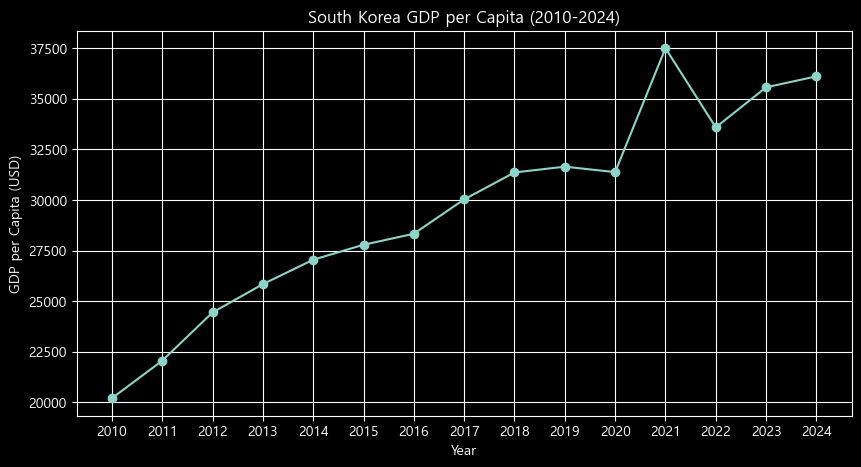


🔄 Node: agent in [Coder] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  Python_REPL (call_Q2bi7DieCEdYNCipigCAVr53)
 Call ID: call_Q2bi7DieCEdYNCipigCAVr53
  Args:
    query: import matplotlib.pyplot as plt
import platform
import matplotlib.font_manager as fm

# OS 판단
current_os = platform.system()

if current_os == "Windows":
    # Windows 환경 폰트 설정
    font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕 폰트 경로
    fontprop = fm.FontProperties(fname=font_path, size=12)
    plt.rc("font", family=fontprop.get_name())
elif current_os == "Darwin":  # macOS
    # Mac 환경 폰트 설정
    plt.rcParams["font.family"] = "AppleGothic"
else:  # Linux 등 기타 OS
    # 기본 한글 폰트 설정 시도
    try:
        plt.rcParams["font.family"] = "NanumGothic"
    except:
        print("한글 폰트를 찾을 수 없습니다. 시스템 기본 폰트를 사용합니다.")

# 마이너스 폰트 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False  # 마이너스 폰트 깨짐 방지

# 연도와 1인당 GDP 데이터
years = 

In [12]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, invoke_graph

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = {
    "messages": [
        HumanMessage(
            content="2010년 ~ 2024년까지의 대한민국의 1인당 GDP 추이를 그래프로 시각화 해주세요."
        )
    ],
}

# 그래프 실행
invoke_graph(graph, inputs, config)